In [83]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

from sklearn.preprocessing import StandardScaler

In [12]:
df = pd.read_csv('OutputFeatures.csv')
features_to_disregard = ['Feature1', 'Feature6', 'Feature7', 'Feature8', 'Feature15']
df = df.drop(columns=features_to_disregard)

In [13]:
df.head()

,Target1,Feature0,Feature2,Feature3,Feature4,Feature5,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14
0,568.0,YS,18.9,bar,100,longitudinal,979,111,739,222,600,1000
1,479.0,YS,300.0,bar,100,longitudinal,979,111,739,222,600,1000
2,453.0,YS,400.0,bar,100,longitudinal,979,111,739,222,600,1000
3,404.0,YS,500.0,bar,100,longitudinal,979,111,739,222,600,1000
4,284.0,YS,600.0,bar,100,longitudinal,979,111,739,222,600,1000


In [16]:
categorical_features = ['Feature0', 'Feature3', 'Feature5']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded.head()

,Target1,Feature2,Feature4,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature0_YS,Feature3_plate,Feature5_radial,Feature5_transverse
0,568.0,18.9,100,979,111,739,222,600,1000,True,False,False,False
1,479.0,300.0,100,979,111,739,222,600,1000,True,False,False,False
2,453.0,400.0,100,979,111,739,222,600,1000,True,False,False,False
3,404.0,500.0,100,979,111,739,222,600,1000,True,False,False,False
4,284.0,600.0,100,979,111,739,222,600,1000,True,False,False,False


In [37]:
y_unscaled = df_encoded['Target1']
X_unscaled= df_encoded.drop(columns=['Target1'])

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X_unscaled)
y = scaler_y.fit_transform(y_unscaled.values.reshape(-1, 1)).flatten()

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

print(f"X tensor shape: {X.shape}")
print(f"y tensor shape: {y.shape}")

X tensor shape: torch.Size([293, 12])
y tensor shape: torch.Size([293, 1])


In [40]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size1)
        self.fc4 = nn.Linear(hidden_size1, output_size)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [41]:
dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [42]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [43]:
learning_rate = 4e-3
weight_decay = 1e-5
model = Model(input_size=12, hidden_size1=32, hidden_size2=32, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [48]:
epochs = 50
Losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    Losses.append(total_loss)  
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')

Epoch [5/50], Loss: 0.0105
Epoch [10/50], Loss: 0.0102
Epoch [15/50], Loss: 0.0111
Epoch [20/50], Loss: 0.0097
Epoch [25/50], Loss: 0.0099
Epoch [30/50], Loss: 0.0088
Epoch [35/50], Loss: 0.0100
Epoch [40/50], Loss: 0.0095
Epoch [45/50], Loss: 0.0092
Epoch [50/50], Loss: 0.0118


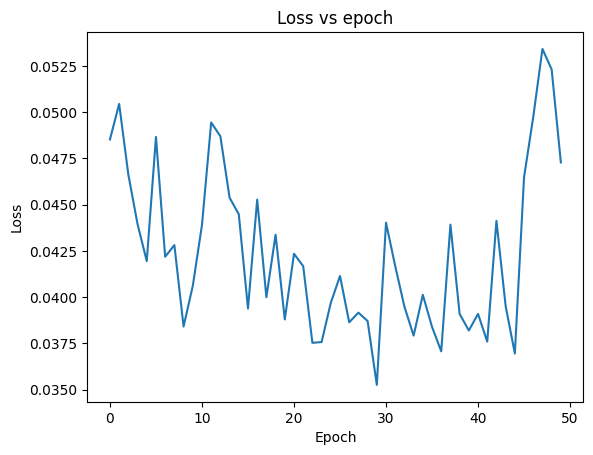

In [51]:
plt.plot(Losses)
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [67]:
model.eval()
test_loss = 0
Pred=[]
with torch.no_grad():
    for test_X, test_y in test_dataset:
        predictions = model(test_X)
        loss = criterion(predictions, test_y)
        test_loss += loss.item()
        Pred.append(scaler_y.inverse_transform([predictions.detach().numpy()])[0][0])

print(f'Test Loss: {test_loss / len(test_dataset):.4f}')

Test Loss: 0.0492


In [99]:
x_test, y_test = zip(*test_dataset)
y_test = torch.tensor(y_test)
x_test = torch.stack(x_test)

y_test_original = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()
x_test_original = scaler_X.inverse_transform(x_test.numpy())

colors = ['blue' if dev <= 0.5 else 'orange' for dev in x_test_original.T[9]]

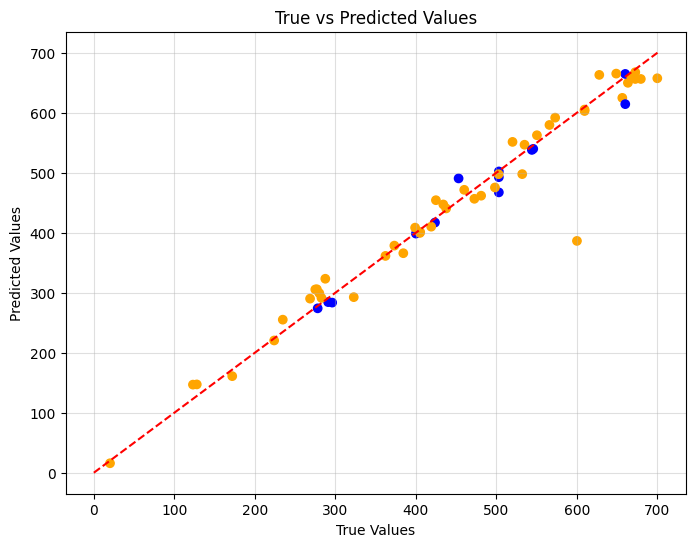

In [100]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, Pred, c=colors, label='Test points', marker='o')

plt.plot([0, 700], [0, 700], color='red', linestyle='--', label='Perfect Line')

plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(alpha=0.4)
plt.show()